<a href="https://colab.research.google.com/github/StanleyLiangYork/GAN_for_Medical_Image/blob/main/Cycle_GAN_with_Criterion_COVID_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [2]:
import os
import shutil
import random
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import zipfile
import random
from PIL import Image
from matplotlib import pyplot as plt
import re
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow_hub as hub
import cv2
import tensorflow_addons as tfa
import tensorflow_probability as tfp


print(f'Tensorflow Version: {tf.__version__}')

Tensorflow Version: 2.8.0


Set the random seed for replication

In [3]:
tf.random.set_seed(100)

Fetch the COVID-19 X-Ray dataset

In [4]:
if not os.path.exists('covid_set.zip'):
  !wget https://storage.googleapis.com/pet-detect-239118/covid_set.zip ./covid_set.zip

with zipfile.ZipFile('covid_set.zip') as ZipObj:
  ZipObj.extractall()

--2022-05-19 15:41:44--  https://storage.googleapis.com/pet-detect-239118/covid_set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.135.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1233041157 (1.1G) [application/zip]
Saving to: ‘covid_set.zip’

covid_set.zip       100%[===================>]   1.15G   141MB/s    in 7.1s    

2022-05-19 15:41:51 (165 MB/s) - ‘covid_set.zip’ saved [1233041157/1233041157]

--2022-05-19 15:41:51--  http://./covid_set.zip
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2022-05-19 15:41:51--
Total wall clock time: 7.4s
Downloaded: 1 files, 1.1G in 7.1s (165 MB/s)


Set the folders for the experiment

In [5]:
root_dir = '/content/covid_set'
paths = os.listdir(root_dir)

covid = re.compile("COVID")
normal = re.compile("NORMAL")
viral = re.compile("Viral")

covid_path = []
normal_path = []
viral_path = []

In [6]:
for path in paths:
  if covid.match(path):
    covid_path.append(path)
  if normal.match(path):
    normal_path.append(path)
  if viral.match(path):
    viral_path.append(path)

Since we have just a few COVID-19 X-ray images, we separate 50 images for validation, and the rest 169 for training

In [7]:
val_covid_path = covid_path[:50]
covid_path = covid_path[50:]
print(len(val_covid_path))
print(len(covid_path))

50
169


Randomly resample the images

In [8]:
for _ in range(5):
  random_items = random.sample(covid_path, 169)
  covid_path += random_items

print(len(covid_path))

1014


Build a balanced dataset, each class has 1014 images respectively

In [9]:
for i, path in enumerate(covid_path):
  covid_path[i] = root_dir + '/' + path

for i, path in enumerate(normal_path):
  normal_path[i] = root_dir + '/' + path

for i, path in enumerate(viral_path):
  viral_path[i] = root_dir + '/' + path


# 1014 + 50 = 1064 -- need 50 extra images from normal and from viral classes for the validation dataset
covid_path = covid_path
normal_path = normal_path[:1064]
viral_path = viral_path[:1064]

In [10]:
print(len(covid_path))
print(len(normal_path))
print(len(viral_path))

1014
1064
1064


The helper function the resize and rescale the images.<p>
labels: COVID-0, NORMAL-1, VIRAL-2

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [128, 128])


def get_label(file_path):
  if tf.strings.regex_full_match(file_path, ".*COVID.*"):
    return tf.constant(0.0, dtype="float32")
  elif tf.strings.regex_full_match(file_path, ".*NORMAL.*"):
    return tf.constant(1.0, dtype="float32")
  else:
    return tf.constant(2.0, dtype="float32")


def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)

  # rescale from (0,255) to (0,1)
  # img = img / 255.0
  img = (img - 127.5) / 127.5
  return img, label

The three image datasets for each image class 

In [12]:
covid_ds = tf.data.Dataset.list_files(covid_path, shuffle=True)
normal_ds = tf.data.Dataset.list_files(normal_path[:1014], shuffle=True)
viral_ds = tf.data.Dataset.list_files(viral_path[:1014], shuffle=True)

In [13]:
BATCH_SIZE = 64
BUFFER_SIZE = 1014
AUTOTUNE = tf.data.AUTOTUNE

covid_ds = covid_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
normal_ds = normal_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
viral_ds = viral_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [14]:
train_path = covid_path + normal_path[:1014] + viral_path[:1014]
val_path = val_covid_path + normal_path[1014:] + viral_path[1014:]
print(len(train_path))
print(len(val_path))

3042
150


In [15]:
train_ds = tf.data.Dataset.list_files(train_path, shuffle=True)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(3042).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.list_files(val_path, shuffle=True)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(150).batch(BATCH_SIZE)

In [16]:
images, labels = next(iter(train_ds))
print(labels)

tf.Tensor(
[1. 0. 0. 2. 2. 2. 2. 0. 2. 0. 1. 1. 0. 2. 1. 2. 0. 1. 2. 1. 1. 1. 2. 1.
 0. 0. 0. 1. 1. 1. 0. 2. 2. 0. 0. 1. 2. 2. 0. 0. 2. 2. 2. 2. 2. 1. 0. 1.
 1. 2. 1. 2. 2. 0. 0. 0. 1. 1. 1. 1. 1. 0. 2. 1.], shape=(64,), dtype=float32)


visualize the images

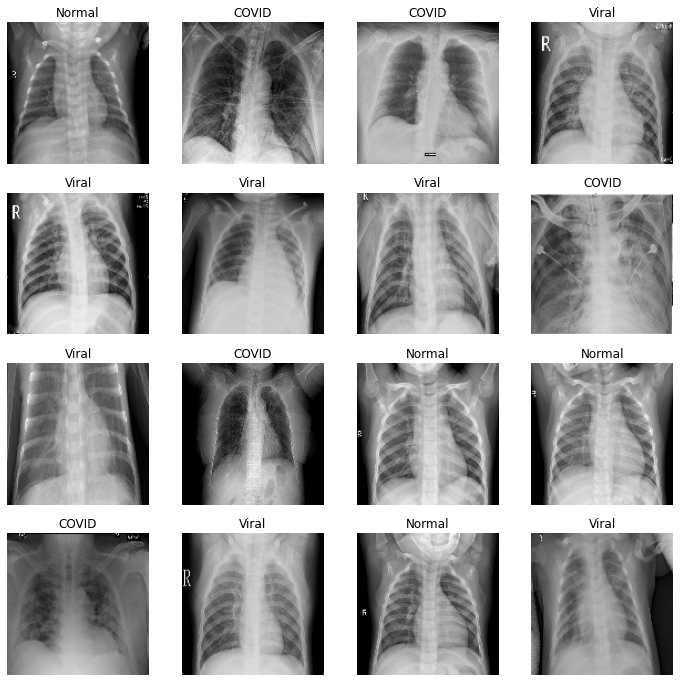

In [17]:
plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  image = tf.keras.preprocessing.image.array_to_img(images[i,:,:,:])
  plt.imshow(image)
  if labels[i] == 0.0:
    plt.title('COVID')
  if labels[i] == 1.0:
    plt.title("Normal")
  if labels[i] == 2.0:
    plt.title("Viral")

Train the classifier later as the criterion for the GAN

In [18]:
# function for creating an identity or projection residual module
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = tfkl.Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = tfkl.Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = tfk.layers.Add()([conv2, merge_input])
	# activation function
	layer_out = tfkl.Activation('relu')(layer_out)
	return layer_out

In [19]:
def define_classifier(input_dim=(128,128,3)):
  input_layer = tfk.Input(shape=input_dim)
  layer = tfkl.Lambda(lambda x: x*127.5+127.5)(input_layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = residual_module(layer, 64)
  layer = tfkl.BatchNormalization()(layer)
  layer = tfkl.MaxPooling2D()(layer)
  layer = tfkl.Flatten()(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(128, activation='tanh')(layer)
  layer = tfkl.Dropout(0.4)(layer)
  layer = tfkl.Dense(3)(layer)
  model = tfk.models.Model(inputs=input_layer, outputs=layer)
  return model

In [20]:
classifier = define_classifier()
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  1792        ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Compile the classifer DNN with sparce categorical crossentropy as the loss function, the input label with shape (batch, 1), the DNN output with shape (batch, 3)

In [21]:
classifier.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4),
    loss=tfk.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Optimize with 60 epochs

In [22]:
history = classifier.fit(train_ds, validation_data=val_ds, epochs=60, callbacks=[callback], verbose=2)

Epoch 1/60
48/48 - 69s - loss: 0.6126 - accuracy: 0.7518 - val_loss: 2.1630 - val_accuracy: 0.5000 - 69s/epoch - 1s/step
Epoch 2/60
48/48 - 55s - loss: 0.2453 - accuracy: 0.9122 - val_loss: 0.5884 - val_accuracy: 0.8000 - 55s/epoch - 1s/step
Epoch 3/60
48/48 - 54s - loss: 0.1799 - accuracy: 0.9405 - val_loss: 0.7898 - val_accuracy: 0.6500 - 54s/epoch - 1s/step
Epoch 4/60
48/48 - 53s - loss: 0.1187 - accuracy: 0.9612 - val_loss: 0.5154 - val_accuracy: 0.7700 - 53s/epoch - 1s/step
Epoch 5/60
48/48 - 53s - loss: 0.0888 - accuracy: 0.9740 - val_loss: 0.7431 - val_accuracy: 0.6700 - 53s/epoch - 1s/step
Epoch 6/60
48/48 - 53s - loss: 0.0717 - accuracy: 0.9780 - val_loss: 0.3378 - val_accuracy: 0.8700 - 53s/epoch - 1s/step
Epoch 7/60
48/48 - 53s - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.2608 - val_accuracy: 0.9000 - 53s/epoch - 1s/step
Epoch 8/60
48/48 - 53s - loss: 0.0414 - accuracy: 0.9885 - val_loss: 0.2165 - val_accuracy: 0.9400 - 53s/epoch - 1s/step
Epoch 9/60
48/48 - 53s - loss: 0

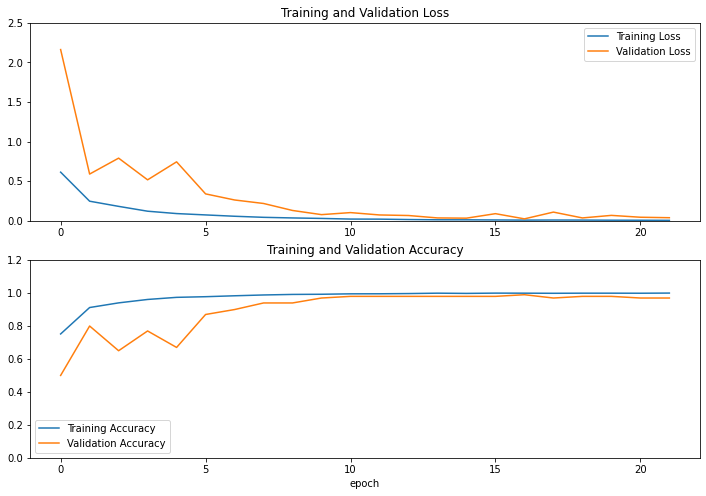

In [23]:
# visualize the training procedure
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylim([0, 2.5])
plt.legend(loc='best')
plt.title('Training and Validation Loss')

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0, 1.2])
plt.plot()
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.savefig('train.png')

In [24]:
# save and zip the classifier
classifier.save('covid_classifier_128')
!zip -r covid_classifier_128.zip covid_classifier_128

INFO:tensorflow:Assets written to: covid_classifier_128/assets
  adding: covid_classifier_128/ (stored 0%)
  adding: covid_classifier_128/assets/ (stored 0%)
  adding: covid_classifier_128/variables/ (stored 0%)
  adding: covid_classifier_128/variables/variables.index (deflated 76%)
  adding: covid_classifier_128/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: covid_classifier_128/saved_model.pb (deflated 90%)
  adding: covid_classifier_128/keras_metadata.pb (deflated 94%)


Now we setup the Cycle-GAN with criterion

In [25]:
# delete and reload the pretrained classifier
del classifier
classifier = tfk.models.load_model('covid_classifier_128')
classifier.trainable = False

In [26]:
# check the pretrained classifier with the validation dataset
classifier.evaluate(val_ds)

2/2 [==============================] - 2s 23ms/step - loss: 0.0365 - accuracy: 0.9700


[0.036462053656578064, 0.9700000286102295]

In [27]:
class_loss = tfk.losses.SparseCategoricalCrossentropy(from_logits=True)

In [28]:
def get_accuracy(g_true, preds):
  pred_idx = tf.argmax(preds, axis=1).numpy()
  count = 0
  for tab, pred in zip(g_true, pred_idx):
    if tab == pred:
      count += 1
  return count / preds.shape[0]

In [29]:
preds = classifier(images)

In [30]:
result = get_accuracy(labels, preds)
print(result)

1.0


In [31]:
loss = class_loss(labels, preds)
print(loss)

tf.Tensor(0.00039805978, shape=(), dtype=float32)


In [32]:
# define the discriminator model
def define_discriminator(image_shape=(128,128,3)):
  init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)
  in_image = tf.keras.Input(shape=image_shape)
  d = tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image) # 64*64*64
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 32*32*128
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 16*16*256
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  d = tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d) # 8*8*512
  d = tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform")(d)
  d = tf.keras.layers.LeakyReLU(alpha=0.2)(d)
  patch_out = tf.keras.layers.Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d) # 8*8*1
  model = tf.keras.Model(inputs=in_image, outputs=patch_out)
  return model

In [33]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tfkl.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [34]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tfkl.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tfa.layers.InstanceNormalization(axis=-1, center=True, scale=True, beta_initializer="random_uniform", gamma_initializer="random_uniform"))

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [35]:
def define_generator():
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  down_stack = [
    downsample(64, 4),  # (bs, 64, 64, 64)
    downsample(128, 4),  # (bs, 32, 64, 128)
    downsample(256, 4),  # (bs, 16, 16, 256)
    downsample(512, 4),  # (bs, 8, 8, 512)
    downsample(512, 4),  # (bs, 4, 4, 512)
    downsample(512, 4),  # (bs, 2, 2, 512)
    downsample(512, 4),  # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (bs, 2, 2, 1024)
    upsample(512, 4),  # (bs, 4, 4, 1024)
    upsample(512, 4),  # (bs, 8, 8, 1024)
    upsample(256, 4),  # (bs, 16, 16, 512)
    upsample(128, 4),  # (bs, 32, 32, 256)
    upsample(64, 4),  # (bs, 64, 64, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 128, 128, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [36]:
image_shape = (128,128,3)

generator_g = define_generator()
generator_f = define_generator()
discriminator_x = define_discriminator(image_shape)
discriminator_y = define_discriminator(image_shape)

In [37]:
discriminator_x.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_26 (  (None, 32, 32, 128)      256       
 InstanceNormalization)                                          
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                           

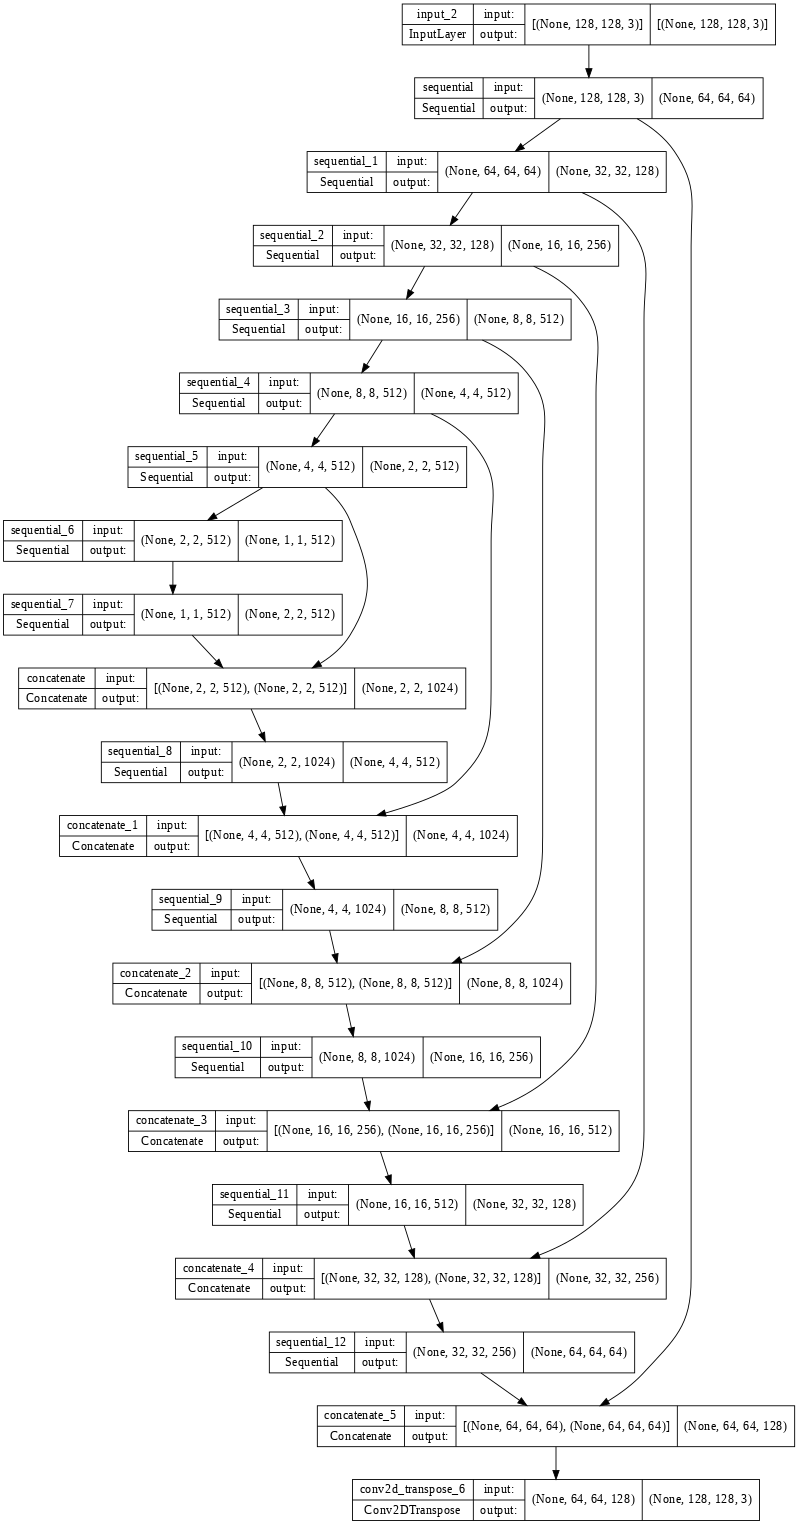

In [38]:
tfk.utils.plot_model(generator_g, show_shapes=True, dpi=64)

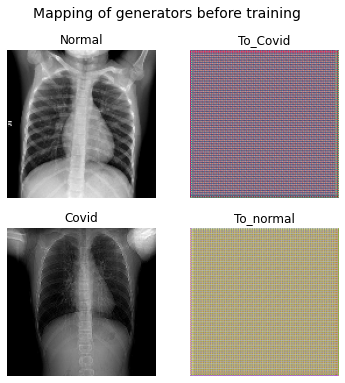

In [39]:
# x -> y: normal -> covid - generator_g
# y -> x: covid -> normal - generator_f

c_images, _ = next(iter(covid_ds))
n_images, _ = next(iter(normal_ds))

to_covid = generator_g(n_images)
to_normal = generator_f(c_images)
plt.figure(figsize=(6, 6))

imgs = [n_images, to_covid, c_images, to_normal]
title = ['Normal', 'To_Covid', 'Covid', 'To_normal']

plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[0][0]))
plt.suptitle("Mapping of generators before training", fontsize=14)
for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  plt.axis(False)
  if i % 2 == 0:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
  else:
    plt.imshow(tf.keras.preprocessing.image.array_to_img(imgs[i][0]))
plt.show()


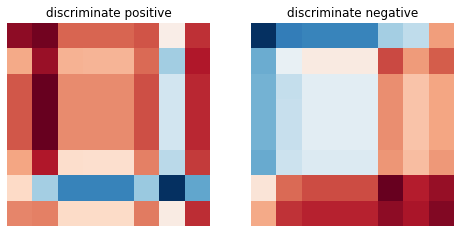

In [40]:
# the hotmap of untrained discriminator
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.title('discriminate positive')
plt.axis(False)
plt.imshow(discriminator_y(c_images)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('discriminate negative')
plt.axis(False)
plt.imshow(discriminator_x(n_images)[0, ..., -1], cmap='RdBu_r')
plt.show()

Define the loss functions for the GAN components

In [41]:
LAMBDA = 80
# alternative: MSE
# loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_obj = tfk.losses.MeanSquaredError()

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5


def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

# prevser color
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [42]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [43]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [44]:
EPOCHS = 600

def generate_images(model, test_input):
  prediction = model(test_input)
  idx = int(np.random.choice(16, 1, replace=False))
  plt.figure(figsize=(10, 10))
  

  display_list = [test_input[idx], prediction[idx]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [45]:
@tf.function
def classify_normal_loss(y, batch_size):
  true_normal = tf.ones([batch_size,1])
  pred_y = classifier(y)
  return class_loss(true_normal, pred_y)


@tf.function
def classify_covid_loss(x, batch_size):
  true_covid = tf.zeros([batch_size,1])
  pred_x = classifier(x)
  return class_loss(true_covid, pred_x)


@tf.function
def classify_viral_loss(x, batch_size):
  true_viral = tf.ones([batch_size,1])*2.0
  pred_x = classifier(x)
  return class_loss(true_viral, pred_x)

In [46]:
@tf.function
def train_step(real_x, real_y, c_flag=True):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  batch_size = real_x.shape[0]
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    # calculate classifier loss
    # true_normal = tf.ones([batch_size,])
    # true_covid = tf.zeros([batch_size,])
    pred_same_x = classifier(same_x)
    pred_same_y = classifier(same_y)
    pred_cycled_x = classifier(cycled_x)
    pred_cycled_y = classifier(cycled_y)

    c_loss_x = classify_normal_loss(same_x, batch_size) + classify_normal_loss(cycled_x, batch_size)
    c_loss_x = c_loss_x * 0.2
    
    c_loss_y = classify_covid_loss(same_y, batch_size) + classify_covid_loss(cycled_y, batch_size)
    c_loss_y = c_loss_y * 0.2

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    if (c_flag):
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y) + c_loss_y
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x) + c_loss_x
    else:
      total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  
  return c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

Build the dataset for the GAN training

In [47]:
def process_gan_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = (img - 127.5) / 127.5
  return img

In [48]:
covid_dataset = tf.data.Dataset.list_files(covid_path, shuffle=True)
normal_dataset = tf.data.Dataset.list_files(normal_path[:1014], shuffle=True)
viral_dataset = tf.data.Dataset.list_files(viral_path[:1014], shuffle=True)

In [49]:
BUFFER_SIZE = 1014
BATCH_SIZE = 64

covid_dataset = covid_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
normal_dataset = normal_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
viral_dataset = viral_dataset.map(process_gan_path, num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

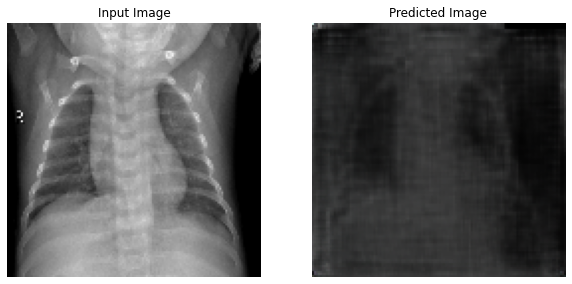

Saving checkpoint for epoch 50 at ./checkpoints/train/ckpt-110
Time taken for epoch 50 is 58.925957441329956 sec



In [61]:
import time
from IPython.display import clear_output
from IPython import display

history = {}
history['class_loss_x'] = []
history['class_loss_y'] = []
history['cycle_loss'] = []
history['total_gen_g_loss'] = []
history['total_gen_f_loss'] = []
history['disc_loss_x'] = []
history['disc_loss_y'] = []

c_loss_x_mean = tfk.metrics.Mean()
c_loss_y_mean = tfk.metrics.Mean()
cycle_loss_mean = tfk.metrics.Mean()
total_gen_g_loss_mean = tfk.metrics.Mean()
total_gen_f_loss_mean = tfk.metrics.Mean()
disc_loss_x_mean = tfk.metrics.Mean()
disc_loss_y_mean = tfk.metrics.Mean()


for epoch in range(50):
  start = time.time()
  c_loss_x_mean.reset_state()
  c_loss_y_mean.reset_state()
  cycle_loss_mean.reset_state()
  total_gen_g_loss_mean.reset_state()
  total_gen_f_loss_mean.reset_state()
  disc_loss_x_mean.reset_state()
  disc_loss_y_mean.reset_state()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((normal_dataset, covid_dataset)):
    if (n % 5 == 0):
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=True) # chang c_flag to False if want to remove the criterion
    else:
      c_loss_x, c_loss_y, total_cycle_loss, total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y, c_flag=False)
    c_loss_x_mean.update_state(c_loss_x)
    c_loss_y_mean.update_state(c_loss_y)
    cycle_loss_mean.update_state(total_cycle_loss)
    total_gen_g_loss_mean.update_state(total_gen_g_loss)
    total_gen_f_loss_mean.update_state(total_gen_f_loss)
    disc_loss_x_mean.update_state(disc_x_loss)
    disc_loss_y_mean.update_state(disc_y_loss)

    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, n_images)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
  history['class_loss_x'].append(c_loss_x_mean.result().numpy())
  history['class_loss_y'].append(c_loss_y_mean.result().numpy())
  history['cycle_loss'].append(cycle_loss_mean.result().numpy())
  history['total_gen_g_loss'].append(total_gen_g_loss_mean.result().numpy())
  history['total_gen_f_loss'].append(total_gen_f_loss_mean.result().numpy())
  history['disc_loss_x'].append(disc_loss_x_mean.result().numpy())
  history['disc_loss_y'].append(disc_loss_y_mean.result().numpy())

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [62]:
# save the trained 
generator_g.save('covid_generator_128')
!zip -r covid_generator_128.zip covid_generator_128

INFO:tensorflow:Assets written to: covid_generator_128/assets
updating: covid_generator_128/ (stored 0%)
updating: covid_generator_128/assets/ (stored 0%)
updating: covid_generator_128/variables/ (stored 0%)
updating: covid_generator_128/variables/variables.index (deflated 66%)
updating: covid_generator_128/variables/variables.data-00000-of-00001 (deflated 7%)
updating: covid_generator_128/saved_model.pb (deflated 92%)
updating: covid_generator_128/keras_metadata.pb (deflated 96%)


Visualize the loss values of the generators and discriminators

Text(0.5, 0, 'epoch')

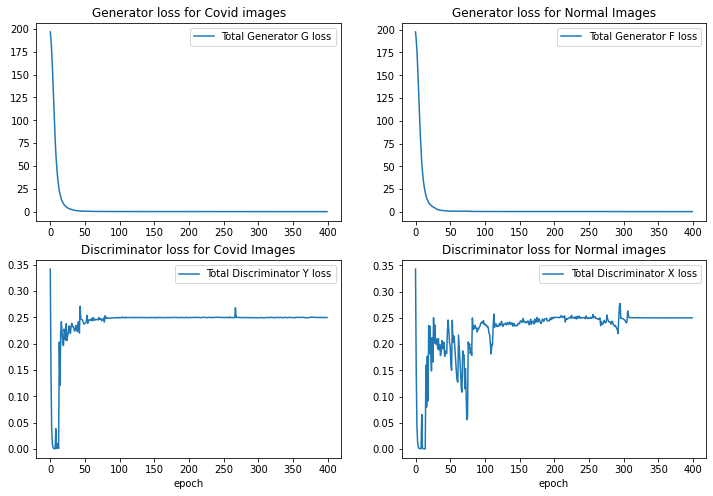

In [52]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history['total_gen_g_loss'], label='Total Generator G loss')
plt.legend(loc='best')
plt.title('Generator loss for Covid images')
# plt.xlabel('epoch')

plt.subplot(2, 2, 2)
plt.plot(history['total_gen_f_loss'], label='Total Generator F loss')
plt.plot()
plt.legend(loc='best')
plt.title('Generator loss for Normal Images')
# plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(history['disc_loss_y'], label='Total Discriminator Y loss')
# plt.ylim([0, 0.02])
plt.plot()
plt.legend(loc='best')
plt.title('Discriminator loss for Covid Images')
plt.xlabel('epoch')

plt.subplot(2, 2, 4)
plt.plot(history['disc_loss_x'], label='Total Discriminator X loss')
# plt.ylim([0, 0.02])
plt.plot()
plt.legend(loc='best')
plt.title('Discriminator loss for Normal images')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

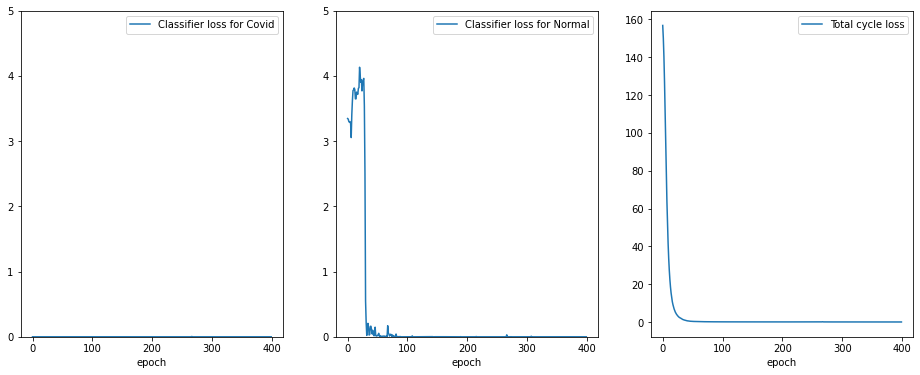

In [53]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
plt.plot(history['class_loss_y'], label='Classifier loss for Covid')
# plt.plot(history['total_gen_g_loss'], label='Generator loss for positive')
plt.ylim([0, 5.0])
plt.legend(loc='best')
# plt.title('Classifier and Generator Loss for Covid')
plt.xlabel('epoch')

plt.subplot(1, 3, 2)
plt.plot(history['class_loss_x'], label='Classifier loss for Normal')
# plt.plot(history['total_gen_f_loss'], label='Generator loss for negative')
plt.ylim([0, 5.0])
plt.plot()
plt.legend(loc='best')
# plt.title('Classifier and Generator Loss for Normal')
plt.xlabel('epoch')

plt.subplot(1, 3, 3)
plt.plot(history['cycle_loss'], label='Total cycle loss')
# plt.ylim([0, 2.5])
plt.plot()
plt.legend(loc='best')
# plt.title('Total cycle loss')
plt.xlabel('epoch')

In [54]:
g_loss = history['total_gen_g_loss']
g_loss = np.array(g_loss)
print(f'Generator G Loss -- Mean: {g_loss.mean()}, Std: {g_loss.std()}, Max: {g_loss.max()}, Min: {g_loss.min()}')

f_loss = history['total_gen_f_loss']
f_loss = np.array(f_loss)
print(f'Generator F Loss -- Mean: {f_loss.mean()}, Std: {f_loss.std()}, Max: {f_loss.max()}, Min: {f_loss.min()}')

Generator G Loss -- Mean: 4.19365119934082, Std: 21.493793487548828, Max: 196.55360412597656, Min: 0.29972779750823975
Generator F Loss -- Mean: 4.376101493835449, Std: 21.814529418945312, Max: 197.59136962890625, Min: 0.30540958046913147


In [55]:
disc_loss_x = history['disc_loss_x']
disc_loss_x = np.array(disc_loss_x)
print(f'Discriminator X Loss -- Mean: {disc_loss_x.mean()}, Std: {disc_loss_x.std()}, Max: {disc_loss_x.max()}, Min: {disc_loss_x.min()}')

disc_loss_y = history['disc_loss_y']
disc_loss_y = np.array(disc_loss_y)
print(f'Discriminator Y Loss -- Mean: {disc_loss_y.mean()}, Std: {disc_loss_y.std()}, Max: {disc_loss_y.max()}, Min: {disc_loss_y.min()}')

Discriminator X Loss -- Mean: 0.2262953817844391, Std: 0.050871703773736954, Max: 0.34292224049568176, Min: 0.00033348987926729023
Discriminator Y Loss -- Mean: 0.24074001610279083, Std: 0.04069855809211731, Max: 0.3417636752128601, Min: 0.0005863659316673875


In [56]:
cycle_loss = history['cycle_loss']
cycle_loss = np.array(cycle_loss)
print(f'Cycle loss -- Mean: {cycle_loss.mean()}, Std: {cycle_loss.std()}, Max: {cycle_loss.max()}, Min: {cycle_loss.min()}')

Cycle loss -- Mean: 3.1621716022491455, Std: 17.199613571166992, Max: 156.7985076904297, Min: 0.042029015719890594


In [57]:
classify_x_loss = history['class_loss_x']
classify_x_loss = np.array(classify_x_loss)
print(f'Classify Normal Image loss -- Mean: {classify_x_loss.mean()}, Std: {classify_x_loss.std()}, Max: {classify_x_loss.max()}, Min: {classify_x_loss.min()}')

classify_y_loss = history['class_loss_y']
classify_y_loss = np.array(classify_y_loss)
print(f'Classify Covid Image loss -- Mean: {classify_y_loss.mean()}, Std: {classify_y_loss.std()}, Max: {classify_y_loss.max()}, Min: {classify_y_loss.min()}')

Classify Normal Image loss -- Mean: 0.27972298860549927, Std: 0.958044707775116, Max: 4.132329940795898, Min: 4.7400121729879174e-06
Classify Covid Image loss -- Mean: 0.0001285883627133444, Std: 0.00025717655080370605, Max: 0.004455136135220528, Min: 7.496735634049401e-06


Visualize synthetic images

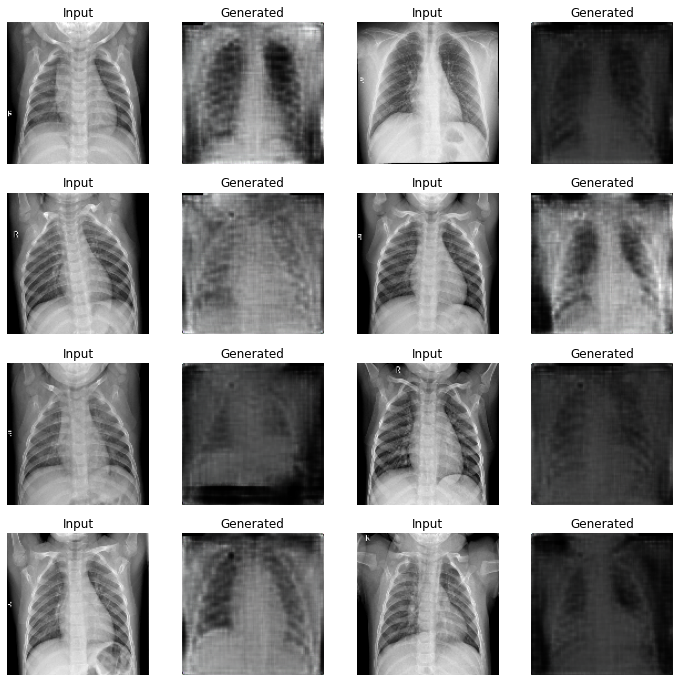

In [63]:
normal_images = next(iter(normal_dataset))
g_image = generator_g(normal_images)

plt.figure(figsize=(12,12))

for i in range(4 * 4):
  plt.subplot(4, 4, 1+i)
  plt.axis(False)
  if i % 2 == 0:
    image = tf.keras.preprocessing.image.array_to_img(normal_images[i,:,:,:])
    plt.imshow(image)
    plt.title('Input')
  else:
    image = tf.keras.preprocessing.image.array_to_img(g_image[i,:,:,:])
    plt.imshow(image)
    plt.title('Generated')

In [65]:
g_true = tf.zeros([64,1]) # 0 - covid positive
preds = classifier(g_image)
acc = get_accuracy(g_true, preds)
print(f'{acc * 100}% of generated images are classified as covid positive')
preds_normal = classifier(normal_images)
l_normal = tf.ones([64, 1])
acc_2 = get_accuracy(l_normal, preds_normal)
print(f'{acc_2*100}% of real normal images are classified as normal')

98.4375% of generated images are classified as covid positive
100.0% of real normal images are classified as normal
